In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import os, os.path 
import pickle
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "valid", "test"]

gpu = torch.device('cuda:0')
cpu = torch.device('cpu')

### Regression Data Set and utility

### Utilities

In [3]:
def get_city_extrema(city):
    max = 0
    min = 0
    for split in splits:
        if split != 'valid':
            f_in = ROOT_PATH + split + "/" + city + "_inputs"
            inputs = pickle.load(open(f_in, "rb"))
            inputs = np.asarray(inputs)
            max = np.max((max, np.max(inputs)))
            min = np.min((min, np.min(inputs)))
        
        if split == 'train':
            f_out = ROOT_PATH + split + "/" + city + "_outputs"
            outputs = pickle.load(open(f_out, "rb"))
            outputs = np.asarray(outputs)
        
            max = np.max((max, np.max(outputs)))
            min = np.min((min, np.min(outputs)))
    return max, min

def normalize_data(X, city):
    max_city = city_extremum[city][0]
    min_city = city_extremum[city][1]
    return (X-min_city)/(max_city-min_city)

def reverse_normalize(y, city):
    max_city = city_extremum[city][0]
    min_city = city_extremum[city][1]
    
    return y*(max_city-min_city) + min_city

In [4]:
def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH
    if split == 'valid' or split == 'train':
        f_in += "train/" + city + "_inputs"
    else:
        f_in += split + "/" + city + "_inputs"
        
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    if normalized:
        inputs = normalize_data(inputs, city)
    
    outputs = None
    if split=="train" or split == 'valid':
        f_out = ROOT_PATH + "train/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)
        if normalized:
            outputs = normalize_data(outputs, city)
        
    if split == 'valid':
        inputs = inputs[:int(len(inputs)/4)]
        outputs = outputs[:int(len(outputs)/4)]
        
    if split == 'train':
        inputs = inputs[int(len(inputs)/4):]
        outputs = outputs[int(len(outputs)/4):]

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, normalized=False, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform
        self.split = split
        
        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=normalized)
            
        self.inputs = torch.from_numpy(self.inputs).to(gpu)
        if not self.split == 'test':
            self.outputs = torch.from_numpy(self.outputs).to(gpu)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        if not self.split == 'test':
            data = (self.inputs[idx], self.outputs[idx])
        else:
            data = self.inputs[idx]
        if self.transform:
            data = self.transform(data)
        return data

In [5]:
city_extremum = {}
for city in cities:
    city_extremum[city] = get_city_extrema(city)

#### Regression Data set

In [5]:
"""city_data is loaded in GPU"""
normalized_city_data = {}
for city in cities:
    normalized_city_data[(city, 'train')] = ArgoverseDataset(city, 'train', True)
    normalized_city_data[(city, 'valid')] = ArgoverseDataset(city, 'valid', True)
    normalized_city_data[(city, 'test')]  = ArgoverseDataset(city, 'test', True)
    
unnormalized_city_data = {}
for city in cities:
    unnormalized_city_data[(city, 'train')] = ArgoverseDataset(city, 'train', False)
    unnormalized_city_data[(city, 'valid')] = ArgoverseDataset(city, 'valid', False)
    unnormalized_city_data[(city, 'test')]  = ArgoverseDataset(city, 'test', False)


### Models

In [6]:
loss = nn.MSELoss()
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
    if type(m) == nn.Conv1d:
        nn.init.normal_(m.weight, std=0.01)

In [7]:
class Accumulator:  #@save
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [8]:
def train_epoch(net, train_data, loss, updater):
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    epoch_loss = Accumulator(1)
    for X, y in train_data:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat,  y.flatten(start_dim=1))
        if isinstance(updater, torch.optim.Optimizer):
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # Using custom built optimizer & loss criterion
            l.sum().backward()
            updater(X.shape[0])
        epoch_loss.add(l)
        
    # Return training loss and training accuracy
    return epoch_loss[0]

def validation(net, valid_data, loss):
    if valid_data == None:
        return 0
    
    if isinstance(net, torch.nn.Module):
        net.eval()
    valid_loss = Accumulator(1)
    with torch.no_grad():
        for X, y in valid_data:
            y_hat = net(X)
            valid_loss.add(loss(y_hat, y.flatten(start_dim=1)))
    return valid_loss[0]

def train(net, train_data, valid_data, loss, num_epochs, updater):
    train_metrics = []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_data, loss, updater)
        valid_loss = validation(net, valid_data, loss)
        train_metrics.append((train_loss, valid_loss))
        if len(train_metrics) > 1 and abs(train_metrics[-1][0] - train_metrics[-2][0]) < 1E-10:
            break
    return np.asarray(train_metrics).T

In [8]:
def run(net, loss, batch_size, num_epoch, updater, normalized=False):
    train_result = {}
    for city in cities:
        net.apply(init_weights)
        train_data = None
        valid_data = None
        if normalized:
            train_data = DataLoader(normalized_city_data[(city, 'train')], batch_size, shuffle=True)
            valid_data = DataLoader(normalized_city_data[(city, 'valid')], batch_size, shuffle=False)
        else:
            train_data = DataLoader(unnormalized_city_data[(city, 'train')], batch_size, shuffle=True)
            valid_data = DataLoader(unnormalized_city_data[(city, 'valid')], batch_size, shuffle=False)
        city_result = train(net, train_data, valid_data, loss, num_epoch, updater)
        train_result[city] = city_result
    return train_result

def save(net, loss, batch_size, num_epoch, updater, model_type, normalized=False):
    """save the neural net parameter for each city

    Args:
        net: the neural network
        batch_size: batch size
        num_epoch: number of epoches
        model_type (str): type of model

    Returns:
        dict : the dictionary of path to the model for each city
    """
    city_model = {}
    for city in cities:
        net.apply(init_weights)
        train_data = None
        if normalized:
            train_data = DataLoader(normalized_city_data[(city, 'train')], batch_size, shuffle=True)
        else:
            train_data = DataLoader(unnormalized_city_data[(city, 'train')], batch_size, shuffle=True)
        train(net, train_data, None, loss, num_epoch, updater)
        torch.save(net.state_dict(), ROOT_PATH+"model/"+model_type+'_'+city)
        city_model[city] = ROOT_PATH+"model/"+model_type+'_'+city
    return city_model

def prediction(net, models, batch_size, normalized=False):
    """
    Make predictions for each city. 
    net is the neual network. 
    models is the dictionary of net parameters for each city.
    """
    city_pred = {}
    for city in cities:
        city_pred[city] = None
        net.load_state_dict(torch.load(models[city]))
        net.eval()
        test_data = None
        if normalized:
            test_data = DataLoader(normalized_city_data[(city, 'test')], batch_size, shuffle=False)
        else:
            test_data = DataLoader(unnormalized_city_data[(city, 'test')], batch_size, shuffle=False)
        for X in test_data:
            with torch.no_grad():
                y_hat = net(X)
                if normalized:
                    y_hat = reverse_normalize(y_hat, city)
                if city_pred[city] == None:
                    city_pred[city] = y_hat
                else:
                    city_pred[city] = torch.concat((city_pred[city], y_hat), dim=0)
    return city_pred

def plot_result(result:dict, num_epoch):
    """plot the training loss over epoches for each city"""
    fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10,9), constrained_layout=True)
    for city,ax in zip(result, axes.flat):
        city_train_loss = result[city][0]
        city_valid_loss = result[city][1]
        min_plot_epoch = min(num_epoch, len(city_train_loss))
        ax.plot(np.arange(0, min_plot_epoch, step=1), city_train_loss[:min_plot_epoch])
        ax.plot(np.arange(0, min_plot_epoch, step=1), city_valid_loss[:min_plot_epoch])
        ax.legend([city+'-train', city+'-valid'])
        ax.set_ylabel("Training loss")
        ax.set_xlabel("Number of epoches")
    fig = fig.suptitle("Training Loss over Epoches")
    return fig

def generateSubmissionFile(predictions:dict):
    """predictions is a dictionary {city: predictions}"""
    def generateHeader():
        header = "ID"
        for i in range(120):
            header += ",v"+str(i)
        return header+"\n"
    
    def generateLine(city, scene, prediction):
        output = str(scene)+'_'+city
        for i in prediction:
            output += ','+str(i)
        return output+'\n'

    f_pred = open(ROOT_PATH+"my_submission.csv", "w")
    f_pred.write(generateHeader())
    for city in predictions:
        for id,pred in enumerate(predictions[city]):
            f_pred.write(generateLine(city, id, pred.cpu().numpy()))
    f_pred.close()

Linear regression training time for 200 epchoes with batch size 256: \
4m 23.1 sec on 8 core CPU \
1m 6.6 sec on GPU (1 cuda device)

In [15]:
# Example of the test inputs
testIn = unnormalized_city_data[('austin', 'test')][0].to(cpu)

#### Linear Regression Model

In [10]:
linear = nn.Sequential(nn.Flatten(), nn.Linear(100, 120)).to(gpu).double()
linear_trainer = torch.optim.SGD(linear.parameters(), lr=0.1, momentum=0.9)
linear_train_result = run(linear, loss, batch_size=256, num_epoch=100, updater=linear_trainer, normalized=True)

Text(0.5, 0.98, 'Training Loss over Epoches')

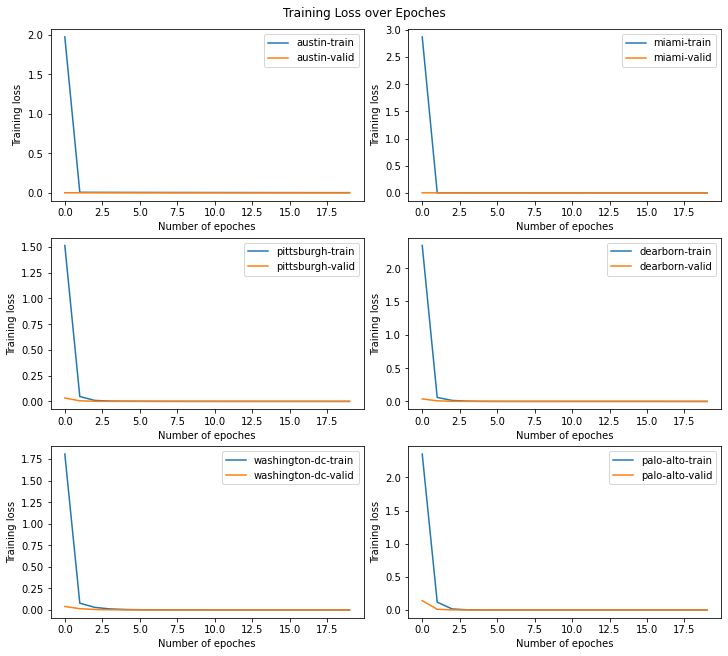

In [11]:
plot_result(linear_train_result, 20)

In [12]:
linear_models = save(linear, loss, batch_size =256, num_epoch=5, updater=linear_trainer, model_type="LinearRegression", normalized=True)
linear_predictions = prediction(linear, linear_models, 256, normalized=True)

In [17]:
linearTestOut = linear_predictions['austin'][0].to(cpu)
linearTestOut = torch.reshape(linearTestOut, (60,2))

Linear model best score: 5531.74150

#### MLP model

In [20]:
MLP = nn.Sequential(nn.Flatten(), nn.Linear(100, 512),
                     nn.Sigmoid(),
                     nn.Linear(512, 256),
                     nn.Sigmoid(),
                     nn.Linear(256, 120)).to(gpu).double()
MLP_trainer = torch.optim.SGD(MLP.parameters(), lr=0.01, momentum=0.9)

In [25]:
MLP_train_result = run(MLP, loss, batch_size=256, num_epoch=100, updater=MLP_trainer, normalized=False)

Text(0.5, 0.98, 'Training Loss over Epoches')

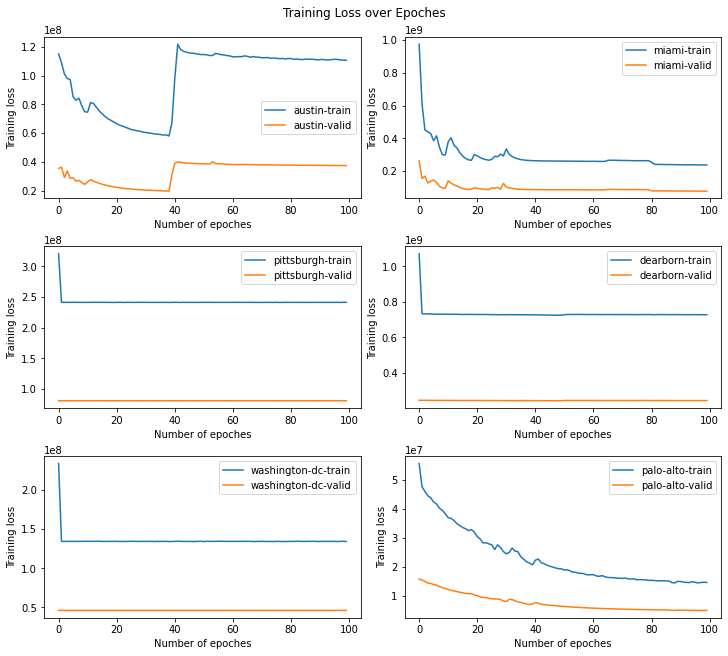

In [29]:
plot_result(MLP_train_result, 100)

In [30]:
MLP_models = save(MLP, loss, batch_size =256, num_epoch=30, updater=MLP_trainer, model_type="MLP", normalized=False)
MLP_predictions = prediction(MLP, MLP_models, 256, normalized=False)

In [31]:
MLPTestOut = MLP_predictions['austin'][0].to(cpu)
MLPTestOut = torch.reshape(MLPTestOut, (60,2))

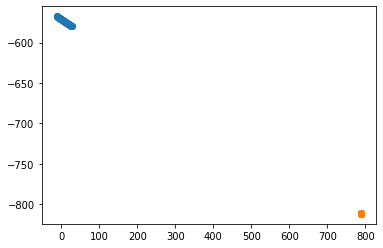

In [32]:
fig = plt.figure()
plt.scatter(testIn[:,0], testIn[:,1])
plt.scatter(MLPTestOut[:,0], MLPTestOut[:,1])

MLP score: 113948190.51986

#### CNN

In [47]:
def CNN_Model(kernal_size=1, stride_size=1, layer_sizes=[120]):
    CNN_out_features = int((50-kernal_size)/stride_size + 1)
    CNN_layers = [nn.Conv1d(50, 50, 2, device=gpu),
                  nn.Flatten(),
                  nn.Unflatten(1, (1,50)),
                  nn.Conv1d(1,1,kernal_size, stride=stride_size, device=gpu),
                  nn.Flatten()]
    prev_layer_size = None
    for curr_layer_size in layer_sizes:
        if prev_layer_size == None:
            CNN_layers.append(nn.Linear(CNN_out_features, curr_layer_size, device=gpu))
        else:
            CNN_layers.append(nn.Sigmoid())
            CNN_layers.append(nn.Linear(prev_layer_size, curr_layer_size, device=gpu))
        prev_layer_size = curr_layer_size
    return nn.Sequential(*CNN_layers).double()

##### CNN1

In [48]:
CNN1 = CNN_Model(20,3)
CNN1_trainer = torch.optim.SGD(CNN1.parameters(), lr=0.1, momentum=0.9)

In [49]:
CNN1_train_result = run(CNN1, loss, batch_size=256, num_epoch=100, updater=CNN1_trainer, normalized=True)

Text(0.5, 0.98, 'Training Loss over Epoches')

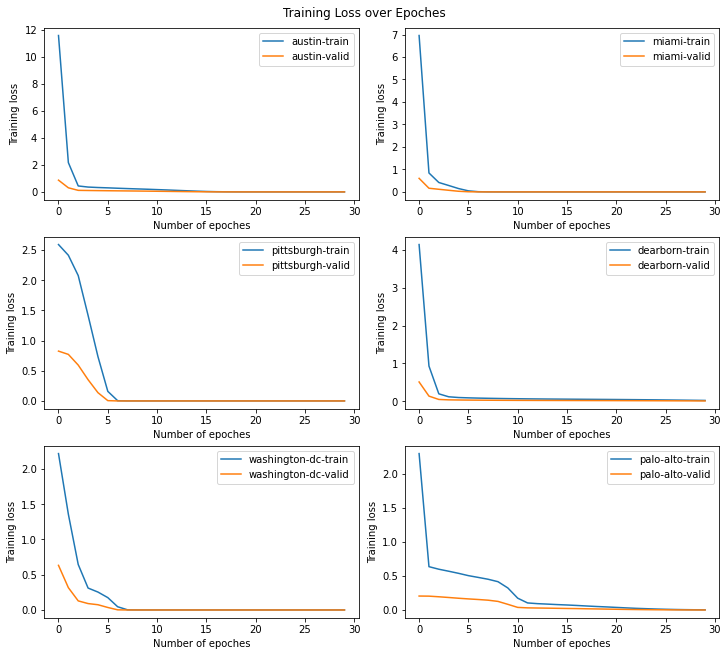

In [50]:
plot_result(CNN1_train_result, 30)

In [51]:
CNN1_models = save(CNN1, loss, batch_size =256, num_epoch=15, updater=CNN1_trainer, model_type="CNN1", normalized=True)
CNN1_predictions = prediction(CNN1, CNN1_models, 256, normalized=True)

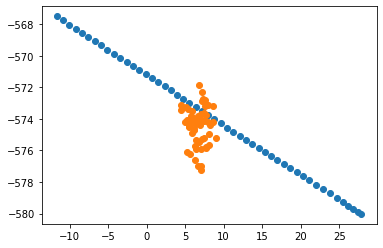

In [52]:
CNN1TestOut = CNN1_predictions['austin'][0].to(cpu)
CNN1TestOut = torch.reshape(CNN1TestOut, (60,2))
fig = plt.figure()
plt.scatter(testIn[:,0], testIn[:,1])
plt.scatter(CNN1TestOut[:,0], CNN1TestOut[:,1])

In [53]:
generateSubmissionFile(CNN1_predictions)

##### CNN2

In [63]:
CNN2 = CNN_Model(5,1, [512, 256, 120])
CNN2_trainer = torch.optim.SGD(CNN2.parameters(), lr=0.01, momentum=0.9)
CNN2_train_result = run(CNN2, loss, batch_size=256, num_epoch=50, updater=CNN2_trainer, normalized=True)

Text(0.5, 0.98, 'Training Loss over Epoches')

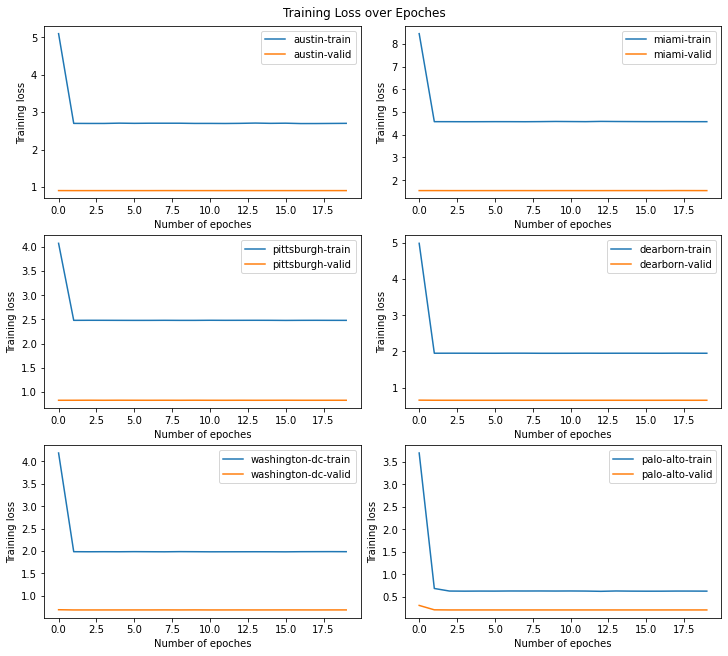

In [64]:
plot_result(CNN2_train_result, 20)

In [65]:
CNN2_models = save(CNN2, loss, batch_size =256, num_epoch=5, updater=CNN2_trainer, model_type="CNN2", normalized=True)
CNN2_predictions = prediction(CNN2, CNN2_models, 256, normalized=True)

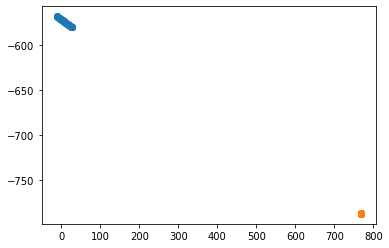

In [66]:
CNN2TestOut = CNN2_predictions['austin'][0].to(cpu)
CNN2TestOut = torch.reshape(CNN2TestOut, (60,2))
fig = plt.figure()
plt.scatter(testIn[:,0], testIn[:,1])
plt.scatter(CNN2TestOut[:,0], CNN2TestOut[:,1])

##### CNN2 hyper parameter tuning

In [473]:
kernal_sizes = [5,10,15,20,25,30]
stride_sizes = [1,2,3,4,5,10,15,20]
model_hyper_param = []
valid_losses = []
for k in kernal_sizes:
    for s in stride_sizes:
        CNN = CNN_Model(k,s, [512, 256, 120])
        CNN_trainer = torch.optim.SGD(CNN.parameters(), lr=0.05, momentum=0.9)
        CNN_train_result = run(CNN, loss, batch_size=256, num_epoch=10, updater=CNN_trainer)
        valid_loss = np.mean([CNN_train_result[city][:][1] for city in CNN_train_result])
        valid_losses.append(valid_loss)
        model_hyper_param.append(f"kernal size-{k}, stride-{s}")

In [480]:
print(model_hyper_param[np.argmin(valid_losses)])

kernal size-25, stride-4


In [481]:
learning_rates = [0.25, 0.2, 0.15, 0.1, 0.05, 0.01]
lr_losses = []
for lr in learning_rates:
    CNN = CNN_Model(25,4, [512, 256, 120])
    CNN_trainer = torch.optim.SGD(CNN.parameters(), lr, momentum=0.9)
    CNN_train_result = run(CNN, loss, batch_size=256, num_epoch=10, updater=CNN_trainer)
    valid_loss = np.mean([CNN_train_result[city][:][1] for city in CNN_train_result])
    lr_losses.append(valid_loss)
print(learning_rates[np.argmin(lr_losses)])

0.01


#### LSTM

##### LSTM Model

In [96]:
class LSTM(nn.Module):
    def __init__(self, input_size=2, hidden_dim=128, n_layers=1, device=gpu):
        super(LSTM, self).__init__()
        self.device = device
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_size=self.input_size, 
                            hidden_size=hidden_dim, 
                            num_layers=n_layers, 
                            batch_first=True).to(device).double()
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, self.input_size).to(device).double()
    
    def forward(self, X):
        
        batch_size = X.size(0)

        # Initializing hidden state for first input using method defined below
        h_0 = torch.zeros(self.n_layers, 
                          batch_size, 
                          self.hidden_dim, 
                          device=self.device, 
                          requires_grad=True, 
                          dtype=torch.double)
        c_0 = torch.zeros(self.n_layers, 
                          batch_size,
                          self.hidden_dim, 
                          device=self.device, 
                          requires_grad=True,
                          dtype=torch.double)

        # Passing input to the model
        ula, (h_out, _) = self.lstm(X, (h_0, c_0))
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(h_out[-1])
        
        return out, h_out
    
    def prediction(self, X, future_preds=60):
        outputs = []
        batch_size, _, seq_len, __ = X.shape
        h_t = torch.zeros(self.n_layers, 
                          batch_size, 
                          self.hidden_dim, 
                          device=self.device, 
                          requires_grad=False, 
                          dtype=torch.double)
        c_t = torch.zeros(self.n_layers, 
                          batch_size,
                          self.hidden_dim, 
                          device=self.device, 
                          requires_grad=False,
                          dtype=torch.double)
        
        with torch.no_grad():
            pred_in = None
            for X_t in X.split(1, dim=1):
                X_t = torch.reshape(X_t, (batch_size, seq_len, self.input_size))
                
                _, (h_t, c_t) = self.lstm(X_t, (h_t, c_t)) # initial hidden and cell states
                output = self.fc(h_t[0]) # output from the last FC layer
                outputs.append(output)
                pred_in = X_t
                
            pred_in[:, -1]= output
            # print(len(outputs))
                
            for i in range(future_preds-1):
                # this only generates future predictions if we pass in future_preds>0
                # mirrors the code above, using last output/prediction as input
                _, (h_t, c_t) = self.lstm(pred_in, (h_t, c_t))
                output = self.fc(h_t[0])
                outputs.append(output)
                pred_in[:, -1]= output
            
            return torch.cat(outputs[-future_preds:], dim=1)

def RNN_run(net, loss, batch_size, num_epoch, updater):
    train_result = {}
    for city in cities:
        print(city+": ")
        net.apply(init_weights)
        train_data = DataLoader(RNN_dt[(city, 'train')], batch_size, shuffle=True)
        valid_data = DataLoader(RNN_dt[(city, 'valid')], batch_size, shuffle=False)
        city_result = RNN_train(net, train_data, valid_data, loss, num_epoch, updater)
        train_result[city] = city_result
        break
    return train_result

def RNN_train(net, train_data, valid_data, loss, num_epochs, updater):
    train_metrics = []
    for epoch in range(num_epochs):
        train_loss = RNN_train_epoch(net, train_data, loss, updater)
        valid_loss = RNN_validation(net, valid_data, loss)
        train_metrics.append((train_loss, valid_loss))
        if (epoch+1)%int(0.1*num_epochs) == 0:
            print(f"{epoch}/{num_epochs} ..... {train_loss}, {valid_loss}")
        if len(train_metrics) > 1 and abs(train_metrics[-1][0] - train_metrics[-2][0]) < 1E-10:
            break
    return np.asarray(train_metrics).T

def RNN_train_epoch(net, train_data, loss, updater):
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    epoch_loss = Accumulator(1)
    for X, y in train_data:
        # Initialize the gradient
        updater.zero_grad()
        
        # Compute gradients and update parameters
        y_hat,_ = net(X)
        l = loss(y_hat,  y)
        
        l.backward()
        updater.step()
        
        epoch_loss.add(l)
        
    # Return training loss and training accuracy
    return epoch_loss[0]
    
def RNN_validation(net, valid_data, loss):
    if valid_data == None:
        return 0
    
    if isinstance(net, torch.nn.Module):
        net.eval()
    valid_loss = Accumulator(1)
    with torch.no_grad():
        for X, y in valid_data:
            y_hat,_ = net(X)
            valid_loss.add(loss(y_hat, y))
    return valid_loss[0]

def RNN_save(net, loss, batch_size, num_epoch, updater, model_type):
    """save the neural net parameter for each city

    Args:
        net: the neural network
        batch_size: batch size
        num_epoch: number of epoches
        model_type (str): type of model

    Returns:
        dict : the dictionary of path to the model for each city
    """
    city_model = {}
    for city in cities:
        net.apply(init_weights)
        train_data = DataLoader(RNN_dt[(city, 'train')], batch_size, shuffle=True)
        RNN_train(net, train_data, None, loss, num_epoch, updater)
        torch.save(net.state_dict(), ROOT_PATH+"model/"+model_type+'_'+city)
        city_model[city] = ROOT_PATH+"model/"+model_type+'_'+city
    return city_model

def RN_prediction(net, models, batch_size=256):
    """
    Make predictions for each city. 
    net is the neual network. 
    models is the dictionary of net parameters for each city.
    """
    city_pred = {}
    for city in cities:
        city_pred[city] = None
        net.load_state_dict(torch.load(models[city]))
        net.eval()
        test_data = None
        test_data = DataLoader(RNN_dt[(city, 'test')], batch_size, shuffle=False)
        for X in test_data:
            with torch.no_grad():
                y_hat = net(X)
                y_hat = reverse_normalize(y_hat, city)
                if city_pred[city] == None:
                    city_pred[city] = y_hat
                else:
                    city_pred[city] = torch.concat((city_pred[city], y_hat), dim=0)
    return city_pred
    
def RNN_save(net, city, model_name):
    """save the neural net parameter for each city

    Args:
        net: the neural network
        model_type (str): type of model

    Returns:
        dict : the dictionary of path to the model for each city
    """
    torch.save(net.state_dict(), ROOT_PATH+"model/"+model_name+'_'+city)
    return ROOT_PATH+"model/"+model_name+'_'+city

Example Model

In [201]:
testModel = LSTM(input_size=2, hidden_dim=2, device=cpu)
testA = torch.ones(2, 4, 2, 2, dtype=torch.double) # batch_size=2, num_seq=4, seq_len=2, num_features=2
testPred = testModel.prediction(testA, 1)[-1]
print(testPred)

tensor([[ 0.4525, -0.3709],
        [ 0.4525, -0.3709]], dtype=torch.float64)


##### Data sequencing

In [9]:
def sliding_widow(data, seq_length=3, split='train'):
    inputSeq = []
    outputTarget = []
    output_length = 0
    if split == 'test':
        output_length = len(data)-seq_length+1
    else:
        output_length = len(data)-seq_length-1
    for i in range(output_length):
        _x = data[i:(i+seq_length)]
        inputSeq.append(_x)
        if not split == 'test':
            _y = data[i+seq_length]
            outputTarget.append(_y)
    return inputSeq, outputTarget

def LSTMData(seq_length=3, city="palo-alto", split="train", normalized=True):
    rawIn, rawout = get_city_trajectories(city, split, normalized=normalized)
    rawData = None
    if split != 'test':
        rawData = np.concatenate((rawIn, rawout), axis=1)
    else:
        rawData = rawIn
    inputs = []
    outputs = []
    for dt in rawData:
        input, output = sliding_widow(dt, seq_length, split)
        inputs.append(input)
        outputs.append(output)
        
    return np.asarray(inputs), np.asarray(outputs)
    

In [22]:
# input
testDataX, testDataY = LSTMData(seq_length=10)
testDataX = torch.from_numpy(testDataX).double()
testDataY = torch.from_numpy(testDataY).double()
secenes, num_seq, seq_len, input_size = testDataX.shape
print(testDataX.shape)
print(testDataY.shape)
# print("Number of sequences: {} \nLength of sequences: {}  \nInput size: {}".format(*testDataX.shape))

torch.Size([8995, 99, 10, 2])
torch.Size([8995, 99, 2])


In [11]:
class RNNDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, seq_length:int, city: str, split:str, normalized=False, transform=None):
        super(RNNDataset, self).__init__()
        self.transform = transform
        self.seq_length = seq_length
        self.split = split
        
        if not self.split == 'test':
            self.inputs, self.outputs = LSTMData(seq_length, city=city, split=split, normalized=normalized)
            
            secenes, num_seq, seq_len, input_size = self.inputs.shape
            self.inputs = torch.from_numpy(self.inputs).to(gpu).double()
            self.inputs = torch.reshape(self.inputs, (secenes*num_seq, seq_len, input_size))
            self.outputs = torch.from_numpy(self.outputs).to(gpu).double()
            self.outputs = torch.reshape(self.outputs, (secenes*num_seq, input_size))
        else:
            self.outputs = None
            self.inputs,_  = LSTMData(seq_length, city=city, split=split, normalized=normalized)
            self.inputs = torch.from_numpy(self.inputs).to(gpu).double()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        if not self.split == 'test':
            data = (self.inputs[idx], self.outputs[idx])
        else:
            data = self.inputs[idx]
        if self.transform:
            data = self.transform(data)
        return data

def RNNCityData(seq_length=3):
    city_data ={}
    for city in cities:
        for split in splits:
            print(f"Processing {city} {split} data set")
            city_data[(city, split)] = RNNDataset(seq_length, city, split, normalized=True)
    return city_data

##### RNN dataset

In [12]:
RNN_dt = RNNCityData(seq_length=10)

Processing austin train data set
Processing austin valid data set
Processing austin test data set
Processing miami train data set
Processing miami valid data set
Processing miami test data set
Processing pittsburgh train data set
Processing pittsburgh valid data set
Processing pittsburgh test data set
Processing dearborn train data set
Processing dearborn valid data set
Processing dearborn test data set
Processing washington-dc train data set
Processing washington-dc valid data set
Processing washington-dc test data set
Processing palo-alto train data set
Processing palo-alto valid data set
Processing palo-alto test data set


##### LSTM models

In [99]:
LSTM1 = LSTM(hidden_dim=128, n_layers=2)
LSTM1_trainer = torch.optim.Adam(LSTM1.parameters(), lr=0.01)

##### Batch training time

Training time for the basic LSTM model with 128 hidden variables and SGD optimizer

In [21]:
import time

batch_sizes = [128, 256, 512, 1024, 2048]
for bs in batch_sizes:
    start = time.time()
    RNN_run(LSTM1, nn.MSELoss(), batch_size=bs, num_epoch=1, updater=LSTM1_trainer2)
    end = time.time()
    print(f"For batch size {bs}, {end-start} elapsed")
    

austin: 
0/300 ..... 1.3231396207712995, 0.05803964657230845
For batch size 128, 396.46746468544006 elapsed
austin: 
0/300 ..... 1.0734587689877346, 0.03612189321288459
For batch size 256, 289.4702332019806 elapsed
austin: 
0/300 ..... 0.9928726298396351, 0.024061518274977448
For batch size 512, 348.4394750595093 elapsed
austin: 
0/300 ..... 0.8402278327963724, 0.015721255408855137
For batch size 1024, 292.2890977859497 elapsed
austin: 
0/300 ..... 0.7651648656504288, 0.010551392200214095
For batch size 2048, 300.12506318092346 elapsed


##### Optimizer time

Training time of 20 Epoches for basic LSTM model with 128 hidden variables and Adam optimizer

In [47]:
batch_size = 256
LSTM_train_data = DataLoader(RNN_dt[(city, 'train')], batch_size, shuffle=True)
LSTM_valid_data = DataLoader(RNN_dt[(city, 'valid')], batch_size, shuffle=False)
LSTM_train_result = RNN_train(LSTM1, loss=nn.MSELoss(), train_data=LSTM_train_data, valid_data=LSTM_valid_data, num_epochs=20, updater=LSTM1_trainer2)

1/20 ..... 0.06422428785257887, 0.0023174824239862108
3/20 ..... 0.040378895082566375, 0.007104687772074552
5/20 ..... 0.012046796103500578, 0.00014079924781176944
7/20 ..... 0.008281755623620098, 0.0010103488302475245
9/20 ..... 0.006938566539323619, 0.00012837086716947007
11/20 ..... 0.005544304298396356, 0.0005896723515777987
13/20 ..... 0.005121112033531007, 0.00011077219584769538
15/20 ..... 0.00450649142302506, 5.992798385772475e-05
17/20 ..... 0.00409523503126297, 0.0013856642484009233
19/20 ..... 0.003745494764772932, 0.00010032494136441983


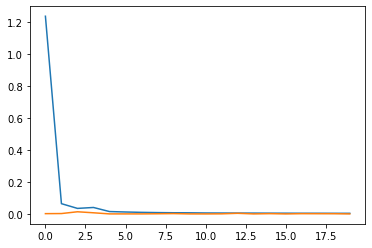

In [48]:
fig = plt.figure()
plt.plot(range(20), LSTM_train_result[0])
plt.plot(range(20), LSTM_train_result[1])

Conclusion: Adam has a faster convergent rate and computation time

In [31]:
RNN_save(LSTM1, 'palo-alto', 'LSTM1')

'./model/LSTM1_palo-alto'

##### Training

In [100]:
loss=nn.MSELoss()
batch_size=256
LSTM1_models ={}
LSTM1_train_results = {}
for city in cities:
    print(f"{city}:  ")
    train_data = DataLoader(RNN_dt[(city, 'train')], batch_size, shuffle=True)
    valid_data = DataLoader(RNN_dt[(city, 'valid')], batch_size, shuffle=False)
    LSTM1_train_results[city] = RNN_train(LSTM1, loss=loss, train_data=train_data, valid_data=valid_data, num_epochs=30, updater=LSTM1_trainer)
    LSTM1_models[city] = RNN_save(LSTM1, city, 'LSTM1')
    

austin:  
2/30 ..... 0.0363299379257263, 0.010181976634805988
5/30 ..... 0.01678336153321422, 0.002912074622214364
8/30 ..... 0.0112885049445561, 0.011423991591877274
11/30 ..... 0.008855248463696582, 0.0005097972165998986
14/30 ..... 0.007615198041399862, 0.0008382213397175475
17/30 ..... 0.006712084938998924, 0.0012547265875901856
20/30 ..... 0.00617102055141091, 7.540787255918267e-05
23/30 ..... 0.005732618743577992, 0.0001878230548525988
26/30 ..... 0.00534202108557088, 0.00040166310759886663
29/30 ..... 0.004985393249904731, 0.0012694397697195327
miami:  
2/30 ..... 0.007662089934468439, 0.022599419184576315
5/30 ..... 0.006840714117803396, 0.0001325855830924137
8/30 ..... 0.006404123624457878, 0.002198950194296006
11/30 ..... 0.006109835785197389, 0.009930450164680646
14/30 ..... 0.005803483367744711, 0.00027772466999482386
17/30 ..... 0.005570567470135364, 0.0002268740216187546
20/30 ..... 0.00547806899580049, 0.0010871880469217037
23/30 ..... 0.005241557540573777, 0.00075525588

Text(0.5, 0.98, 'Training Loss over Epoches')

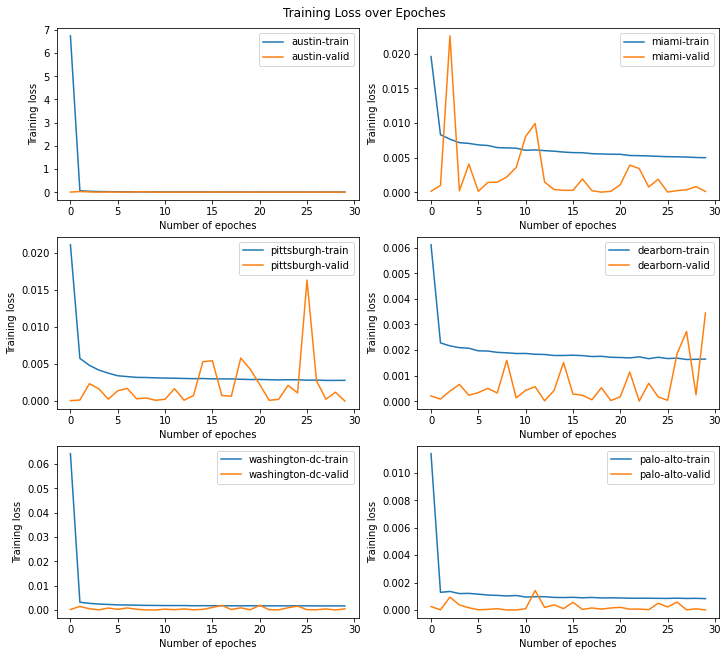

In [101]:
plot_result(LSTM1_train_results, 30)

In [102]:
LSTM1.eval()
city_predictions = {}
for city in cities:
    LSTM1.load_state_dict(torch.load(ROOT_PATH+"/model/LSTM1_"+city))
    test_data = DataLoader(RNN_dt[(city, 'test')], 256, shuffle=False)
    predictions = []
    for X in test_data:
        pred = LSTM1.prediction(X)
        predictions.append(pred)
    predictions = torch.cat(predictions, dim=0)
    city_predictions[city] = reverse_normalize(predictions, city)

In [103]:
generateSubmissionFile(city_predictions)

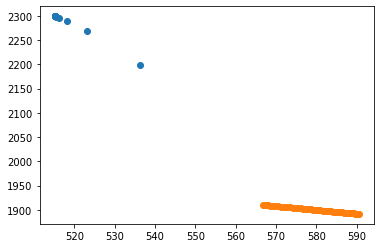

In [80]:
fig = plt.figure()
plt.scatter(palo_predictions[:,0], palo_predictions[:,1])
plt.scatter(testIn[:,0], testIn[:,1])